# MC886 - Aprendizado de Máquina
# Trabalho 3
- Guilherme Ramirez - RA217295
- Frederico Rappa - RA216047

-----------------------------------------------
# Bibliotecas

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
%matplotlib inline
sns.set_style("whitegrid")
FONTSIZE = 20
TICKFONTSIZE = 15

-----------------------------------------------------------------------------------------------------------------
# Funções auxiliares

In [4]:
from util import *
import traceback
import sys, types, time, random, os
from game import Agent, Directions, AgentState, Grid, Actions, GameStateData

In [5]:
from util import nearestPoint
from util import manhattanDistance
from pacman import GameState, loadAgent, parseAgentArgs, ClassicGameRules
import util
import layout as lo

def setConfig(pacman, numGames=1, numTraining=0, layout='mediumClassic', quietGraphics=True, fixRandomSeed=False, agentArgs=None, timeout=30):
    args = dict()
    noKeyboard = True
    if fixRandomSeed:
        random.seed('cs188')

    args['layout'] = lo.getLayout( layout )
    pacmanType = loadAgent(pacman, noKeyboard)
    agentOpts = parseAgentArgs(agentArgs)
    pacman = pacmanType(**agentOpts) 
    args['pacman'] = pacman

    if numTraining > 0:
        args['numTraining'] = numTraining
        if 'numTraining' not in agentOpts: 
            agentOpts['numTraining'] = numTraining

    if 'numTraining' in agentOpts:
        numQuiet = int(agentOpts['numTraining'])
        numIgnore = int(agentOpts['numTraining'])

    ghostType = loadAgent('RandomGhost', noKeyboard)
    args['ghosts'] = [ghostType( i+1 ) for i in range( 4 )]

    # Choose a display format
    if quietGraphics:
        import textDisplay
        args['display'] = textDisplay.NullGraphics()
    else:
        import graphicsDisplay
        args['display'] = graphicsDisplay.PacmanGraphics(options.zoom, frameTime = options.frameTime)
    args['numGames'] = numGames
    args['timeout'] = timeout

    return args


def runGames( layout, pacman, ghosts, display, numGames, numTraining = 0, catchExceptions=False, timeout=30 ):
    print('=====================================================')
    import __main__
    __main__.__dict__['_display'] = display

    rules = ClassicGameRules(timeout)
    games = []

    for i in range( numGames ):
        beQuiet = i < numTraining
        if beQuiet:
                # Suppress output and graphics
            import textDisplay
            gameDisplay = textDisplay.NullGraphics()
            rules.quiet = True
        else:
            gameDisplay = display
            rules.quiet = False
        game = rules.newGame( layout, pacman, ghosts, gameDisplay, beQuiet, catchExceptions)
        totalFood = game.state.getNumFood()
        if numTraining > 0:
            game.run(epsilon = (numTraining - i)/numTraining)
        else:
            game.run()
        games.append(game)
        if (i + 1) % 100 == 0 and i + 1 <= numTraining or i + 1 == numTraining:
            print('Trained episode {}'.format(i+1))
            


    print('=====================================================')
    data={}
    data['numTraining'] = numTraining
    data['numGames'] = numGames
    data['scores'] = np.array([game.state.getScore() for game in games])
    data['wins'] = [game.state.isWin() for game in games]
    data['winRate'] = data['wins'].count(True)/ float(len(data['wins']))
    data['averageScore'] = np.mean(data['scores'])
    data['numFood'] = np.array([game.state.getNumFood() for game in games])
    data['foodEaten'] = np.array([(totalFood - game.state.getNumFood())/totalFood for game in games])
    data['numMoves'] = np.array([game.numMoves for game in games])
    

    return games, data

In [6]:
def getWins(data):
    s = 0
    numWins = np.zeros(data['numGames'])
    for i in range(data['numGames']):
        if data['wins'][i]:
            s += 1
        numWins[i] = s
    return numWins

In [7]:
def mediaMovel(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

-----------------------------------------------------------------------------------------------------------------
# PART I - Evolutionary Model

## Definição do Modelo

# PART II - Reinforcement Learning

## Definição do Modelo

Para a seção de aprendizado por reforço, foi desenvolvido o agente `QLearningAgent`, que utiliza o método Q-Learning.

|  Método         | Explicação |
|:---------:|:---------------:|
| `hasThreateningGhosts` |      Verifica se existem fantasmas ameaçadores na posição     |   
| `getNeighbours` |      Retorna lista de vizinhos acessíveis      |   
| `getValidNeighbours` |      Retorna lista de vizinhos acessíveis e sem fantasmas      |   
| `getClosestFoodDistance` |      Devolve a distância da comida mais próxima, sua posição e a direção que deve ser tomada para que o pacman chegue a ela      |   
| `getClosestGhostDistance` |     Devolve o fantasma não amedrontado mais próximo e sua posição      |   
| `hasThreateningGhostInDirection` |     Verifica se há um fantasma ameaçador em um número máximo de casas a partir do pacman      |   
| `fruitInRadius` |     Devolve o número de frutas em um raio      |   
| `ghostsInRadius` |      Devolve o número de fantasmas amedrontados e ameaçadores em um raio      |   
| `getTileType` |      Devolve qual dos 16 tipos de 'casa' corresponde uma coordenada      |   
| `isTrapped` |      Verifica se o pacman está preso: se há fantasmas bloqueando suas saídas      |   
| `getRelativeQuadrant` |      Devolve o quadrante de uma coordenada relativo ao pacman      |   
| `getQState` |     Mapeia o estado do pacman      |   
| `getRewardFromState` |     Devolve uma recompensa a partir de um estado     |   
| `getAction` |     Devolve a melhor ação do pacman      |  


A cada instante, o pacman está em um de 2048 estados possíveis, definidos pelas seguintes features:
- direção do menor caminho não bloqueado por fantasmas ameaçadores para a comida mais próxima – 4 valores; **(I)** 
- "tipo" da posição em que se encontra o Pacman / configuração dos muros a seu redor – 16 valores; **(II)** 
- variável booleana que indica que pacman está "preso" – 2 valores; **(III)** 
- fantasma ameaçador a 8 blocos de distância em um caminho iniciado nas posições adjacentes ao Pacman – 16 valores; **(IV)** 

A cada momento, o pacman verifica quais ações são legais e executa uma entre as 4 possíveis, se locomovendo para Norte, Sul, Leste e Oeste. A cada ação, o pacman recebe uma recompensa, que é dada da seguinte maneira: se o agente ganha o jogo ou come uma fruta, é recompensado positivamente; se perde o jogo ou não come há mais de 10 turnos, é recompensado negativamente. A implementação exata com os valores das recompensas pode ser vista no método `getRewardFromState`. Esta heurística visa fazer com que o pacman seja recompensado por aumentar seus pontos, vencer o jogo e penalizado por perder o jogo e a penalidade por não comer visa evitar que o agente fique muito tempo no mesmo local, como ocorreu na elaboração do modelo. 

Apesar do número de estados ser pequeno, foi possível ver que generalizam bem o tabuleiro do pacman, uma vez que independem de valores como distância, número total de fantasmas ou configuração do *grid*, de modo que, em teoria, um pacman treinado exaustivamente em uma configuração teria o mesmo comportamento em configurações diferentes. Além disso, notou-se que, em alguns testes, o pacman já vencia jogos com cerca de 100 episódios de treinamento, valor muito inferior ao de outras abordagens testadas pela dupla. Enquanto a *feature* **I** objetiva a inferência do melhor caminho para uma recompensa, a **IV** evita que o pacman vá para locais ameaçadores, mesmo que potencialmente tenham esta recompensa. As demais *features* são úteis para que o pacman fuja de fantasmas. 

Para o treinamento, foi utilizada a política epsilon-greedy: o valor de epsilon começou em 1 e decaiu a 0 até o final do treinamento. Antes da adoção desta política, era utilziado epsilon *constante*, de valor 0.3, mas esta abordagem foi descartada em razão do melhor resultado do epsilon-greedy com o número reduzido de estados. Por outro lado, *gamma* e *alpha* foram mantidos constantes, de valores 0.7 e 0.9, respectivamente, pois notou-se que esta formulação produzia melhores resultados mais rapidamente.  

Em todos os episódios, o critério de parada foi o momento em que o pacman vencia ou perdia o jogo.

A implementação do agente é mostrada abaixo:

In [9]:
from game import Agent
from game import Directions
import random

def enqueue(Q, e):
    Q.append(e)

def dequeue(Q):
    e = Q[0]
    del Q[0]
    return e

def stack(s, e):
    s.append(e)

def pop(s):
    return s.pop()

def isInGraph(x, y, width, height):
    return x >= 0 and y >= 0 and y < height and x < width

class QLearningAgent(Agent):
    QTable = {}
    def __init__( self, alpha = 0.7, gamma = 0.9, epsilon):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.actions = {'North': 0, 'East': 1, 'South': 2, 'West': 3, 'Stop': 4}
        self.foodLeft = -1
        self.stagesWithoutEating = -1

    def hasThreateningGhost(self, x, y, state):
        ghostPositions = state.getGhostPositions()
        ghostStates = state.getGhostStates()
        pacmanPosition = state.getPacmanPosition()
        for i in range(len(ghostPositions)):
            if (x, y) == ghostPositions[i] and ghostStates[i].scaredTimer <= 1:
                return True
        return False

    def getNeighbours(self, x, y, width, height, state):
        n = []
        dir = []
        if state.hasWall(x, y):
            return [], []
        if isInGraph(x - 1, y, width, height) and not state.hasWall(x - 1, y):
            n.append((x - 1, y))
            dir.append('West')
        if isInGraph(x + 1, y, width, height) and not state.hasWall(x + 1, y):
            n.append((x + 1, y))
            dir.append('East')
        if isInGraph(x, y + 1, width, height) and not state.hasWall(x, y + 1):
            n.append((x, y + 1))
            dir.append('North')
        if isInGraph(x, y - 1, width, height) and not state.hasWall(x, y - 1):
            n.append((x, y - 1))
            dir.append('South')
        return n, dir

    def getValidNeighbours(self, x, y, width, height, state):
        n = []
        dir = []
        if state.hasWall(x, y):
            return []
        if isInGraph(x - 1, y, width, height) and not state.hasWall(x - 1, y) and not self.hasThreateningGhost(x - 1, y, state):
            n.append((x - 1, y))
            dir.append('West')
        if isInGraph(x + 1, y, width, height) and not state.hasWall(x + 1, y) and not self.hasThreateningGhost(x + 1, y, state):
            n.append((x + 1, y))
            dir.append('East')
        if isInGraph(x, y + 1, width, height) and not state.hasWall(x, y + 1) and not self.hasThreateningGhost(x, y + 1, state):
            n.append((x, y + 1))
            dir.append('North')
        if isInGraph(x, y - 1, width, height) and not state.hasWall(x, y - 1) and not self.hasThreateningGhost(x, y - 1, state):
            n.append((x, y - 1))
            dir.append('South')
        return n, dir

    def getClosestFoodDistance(self, state):
        width, height = state.data.layout.width, state.data.layout.height
        visited = np.zeros((width, height))
        distanceFromPacman = np.zeros((width, height))
        pacmanPosition = state.getPacmanPosition()
        visited[pacmanPosition] = 1
        Q = []
        directionsQueue = []
        enqueue(Q, pacmanPosition)
        enqueue(directionsQueue, ['Stop'])
        while len(Q) > 0:
            u = dequeue(Q)
            path = dequeue(directionsQueue)
            if distanceFromPacman[u] > 0 and state.hasFood(u[0], u[1]):
                return distanceFromPacman[u], u, path[1]
            neighbours, directions = self.getValidNeighbours(u[0], u[1], width, height, state)
            for v, d in zip(neighbours, directions):
                if np.equal(0, visited[v]):
                    visited[v] = 1
                    distanceFromPacman[v] = distanceFromPacman[u] + 1
                    enqueue(Q, v)
                    npath = list(path)
                    npath.append(d)
                    enqueue(directionsQueue, npath)
            visited[u] = 1
        return 0, pacmanPosition, 'Stop' 

    def getClosestGhostDistance(self, state):
        width, height = state.data.layout.width, state.data.layout.height
        ghosts = state.getGhostPositions()
        visited = np.zeros((width, height))
        distanceFromPacman = - np.ones((width, height))
        pacmanPosition = state.getPacmanPosition()
        distanceFromPacman[pacmanPosition] = 0
        visited[pacmanPosition] = 1
        Q = []
        enqueue(Q, pacmanPosition)
        while len(Q) > 0:
            u = dequeue(Q)
            for ghost in ghosts:
                if distanceFromPacman[u] >= 0 and ghost == u:
                    return distanceFromPacman[u], u
            neighbours, _ = self.getNeighbours(u[0], u[1], width, height, state)
            for v in neighbours:
                if np.equal(0, visited[v]):
                    visited[v] = 1
                    distanceFromPacman[v] = distanceFromPacman[u] + 1
                    enqueue(Q, v)
            visited[u] = 1
        return 0, pacmanPosition

    def hasThreateningGhostInDirection(self, initialPosition, direction, state, maxDist):
        width, height = state.data.layout.width, state.data.layout.height
        ghosts = state.getGhostStates()
        visited = np.zeros((width, height))
        distanceFromPacman = - np.ones((width, height))
        pacmanPosition = state.getPacmanPosition()
        distanceFromPacman[pacmanPosition] = 0
        distanceFromPacman[initialPosition] = 1
        visited[pacmanPosition] = 1
        visited[initialPosition] = 1
        Q = []
        directionsQ = []
        enqueue(Q, initialPosition)
        enqueue(directionsQ, direction)
        while len(Q) > 0:
            u = dequeue(Q)
            lastDirection = dequeue(directionsQ)
            if distanceFromPacman[u] >= maxDist:
                return False
            for ghost in ghosts:
                if distanceFromPacman[u] >= 0 and ghost.getPosition() == u and lastDirection != ghost.getDirection():
                    return True
            neighbours, directions = self.getNeighbours(u[0], u[1], width, height, state)
            for v, d in zip(neighbours, directions):
                if np.equal(0, visited[v]):
                    visited[v] = 1
                    distanceFromPacman[v] = distanceFromPacman[u] + 1
                    enqueue(Q, v)
                    enqueue(directionsQ, d)
            visited[u] = 1
        return False


    def fruitInRadius(self, radius, state):
        width, height = state.data.layout.width, state.data.layout.height
        n = 0
        pacmanPosition = state.getPacmanPosition()
        for x in range(pacmanPosition[0] - radius, pacmanPosition[0] + radius + 1): 
            for y in range(pacmanPosition[1] - radius, pacmanPosition[1] + radius + 1):
                if isInGraph(x, y, width, height) and state.hasFood(x, y):
                    n += 1
        return n

    def ghostsInRadius(self, radius, state):
        width, height = state.data.layout.width, state.data.layout.height
        ghosts, scaredGhosts = 0, 0
        ghostPositions = state.getGhostPositions()
        ghostStates = state.getGhostStates()
        pacmanPosition = state.getPacmanPosition()
        for i in range(len(ghostPositions)):
            if ghostPositions[i][0] >= pacmanPosition[0] - radius and ghostPositions[i][0] <= pacmanPosition[0] + radius and ghostPositions[i][1] >= pacmanPosition[1] - radius and ghostPositions[i][1] <= pacmanPosition[1] + radius:
                ghosts += 1
                if ghostStates[i].scaredTimer > 0:
                    scaredGhosts += 1
        return ghosts, scaredGhosts 

    def getTileType(self, coord, state):
        x, y = coord
        up, down, left, right = 0, 0, 0, 0
        if (state.hasWall(x, y + 1)):
            up = 1
        if (state.hasWall(x, y - 1)):
            down = 1
        if (state.hasWall(x - 1, y)):
            left = 1
        if (state.hasWall(x + 1, y)):
            right = 1
        return 8*up + 4*down + 2*left + right

    def isTrapped(self, state):
        width, height = state.data.layout.width, state.data.layout.height
        visited = np.zeros((width, height))
        pacmanPosition = state.getPacmanPosition()
        visited[pacmanPosition] = 1
        Q = []
        enqueue(Q, pacmanPosition)
        while len(Q) > 0:
            u = dequeue(Q)
            tileType = self.getTileType(u, state)
            if tileType == 0 or tileType == 1 or tileType == 2 or tileType == 4 or tileType == 8:
                return False
            neighbours, _ = self.getValidNeighbours(u[0], u[1], width, height, state)
            for v in neighbours:
                if np.equal(0, visited[v]):
                    visited[v] = 1
                    enqueue(Q, v)
            visited[u] = 1
        return True      
        
    def getRelativeQuadrant(self, pos, pacmanPosition):
        # 2 | 1
        # --.--
        # 3 | 4
        x, y = pos
        pacmanX, pacmanY = pacmanPosition 
        if x > pacmanX and y >= pacmanY:
            return 1
        elif x <= pacmanX and y > pacmanY:
            return 2
        elif x < pacmanX and y <= pacmanY:
            return 3
        elif x >= pacmanX and y < pacmanY:
            return 4
        else:
            return 0

    def hasWon(self, state):
        return state.getNumFood() == 0

    def hasLost(self, state):
        return state.isLose()

    def hasEaten(self, state):
        return self.foodLeft > state.getNumFood()

    def updateFoodLeft(self, state):
        if self.hasEaten(state):
            self.stagesWithoutEating = 0
        else:
            self.stagesWithoutEating += 1
        self.foodLeft = state.getNumFood()

    def getQState(self, state):
        closestFoodDistance, closestFoodPosition, direction = self.getClosestFoodDistance(state)
        fruitIn2Radius = self.fruitInRadius(2, state)
        ghostsInRadius, scaredGhostsInRadius = self.ghostsInRadius(2, state)
        closestGhostDistance, closestGhostPosition = self.getClosestGhostDistance(state)
        pacmanPosition = state.getPacmanPosition()
        distance = 8
        return (self.actions[direction], self.getTileType(pacmanPosition, state), self.isTrapped(state), self.hasThreateningGhostInDirection((pacmanPosition[0] - 1, pacmanPosition[1]), 'West', state, distance), self.hasThreateningGhostInDirection((pacmanPosition[0], pacmanPosition[1] + 1), 'North', state, distance), self.hasThreateningGhostInDirection((pacmanPosition[0] + 1, pacmanPosition[1]), 'East', state, distance), self.hasThreateningGhostInDirection((pacmanPosition[0], pacmanPosition[1] - 1), 'South', state, distance))

    def getRewardFromState(self, state):
        reward = 0        
        if self.hasWon(state):
            reward += 100
        if self.hasLost(state):
            reward -= 150
            return reward
        if self.hasEaten(state):
            reward += 40

        elif self.stagesWithoutEating > 10:
            reward -= 10

        return reward

    def getAction(self, state, training=True, epsilon = 0.3 ):
        self.pacmanPosition = state.getPacmanPosition()
        legal = state.getLegalPacmanActions()
        legal = [a for a in legal if a != Directions.STOP]
        legalIndexes = [self.actions[i] for i in legal]
        newState = self.getQState(state)
        if newState not in QLearningAgent.QTable:
            QLearningAgent.QTable[newState] = np.zeros(5)
        if training:
            self.updateFoodLeft(state)
            if random.uniform(0, 1) < epsilon:
                action = random.choice(legal)
            else:
                action = legal[np.argmax(QLearningAgent.QTable[newState][legalIndexes])] 
            actionIndex = self.actions[action]       
            nextState = self.getQState(state.generateSuccessor(0, action))
            reward = self.getRewardFromState(state.generateSuccessor(0, action))
            if nextState not in QLearningAgent.QTable:
                QLearningAgent.QTable[nextState] = np.zeros(5)
            QLearningAgent.QTable[newState][actionIndex] = (1 - self.alpha) * QLearningAgent.QTable[newState][actionIndex] + self.alpha * (reward + self.gamma * np.max(QLearningAgent.QTable[nextState]))
        else:
            action = legal[np.argmax(QLearningAgent.QTable[newState][legalIndexes])] 
        return action

    @staticmethod
    def resetState():
        QLearningAgent.QTable = {}

## Treinamento 

### mediumClassic
Para esta configuração, são feitos 5000 episódios de treinamento e 1000 de teste

In [30]:
QLearningAgent.resetState()
args = setConfig( 'QLearningAgent', numTraining = 5000, numGames=6000 )
games, data = runGames( **args )

Trained episode 100
Trained episode 200
Trained episode 300
Trained episode 400
Trained episode 500
Trained episode 600
Trained episode 700
Trained episode 800
Trained episode 900
Trained episode 1000
Trained episode 1100
Trained episode 1200
Trained episode 1300
Trained episode 1400
Trained episode 1500
Trained episode 1600
Trained episode 1700
Trained episode 1800
Trained episode 1900
Trained episode 2000
Trained episode 2100
Trained episode 2200
Trained episode 2300
Trained episode 2400
Trained episode 2500
Trained episode 2600
Trained episode 2700
Trained episode 2800
Trained episode 2900
Trained episode 3000
Trained episode 3100
Trained episode 3200
Trained episode 3300
Trained episode 3400
Trained episode 3500
Trained episode 3600
Trained episode 3700
Trained episode 3800
Trained episode 3900
Trained episode 4000
Trained episode 4100
Trained episode 4200
Trained episode 4300
Trained episode 4400
Trained episode 4500
Trained episode 4600
Trained episode 4700
Trained episode 4800
T

Nas células abaixo são traçados alguns gráficos para a observação do comportamento do agente. A linha vertical vermelha indica o fim do período de treinamento. É possível notar pelo gráfico abaixo que, em geral, o pacman alcançava mais comidas com o passar dos episódios, e tal valor se estabilizou nos testes. Este resultado é esperado, dado que parte da recompensa é dada quando o pacman chega a uma comida. Nos 1000 episódios de teste, o agente venceu 24,2% dos jogos.

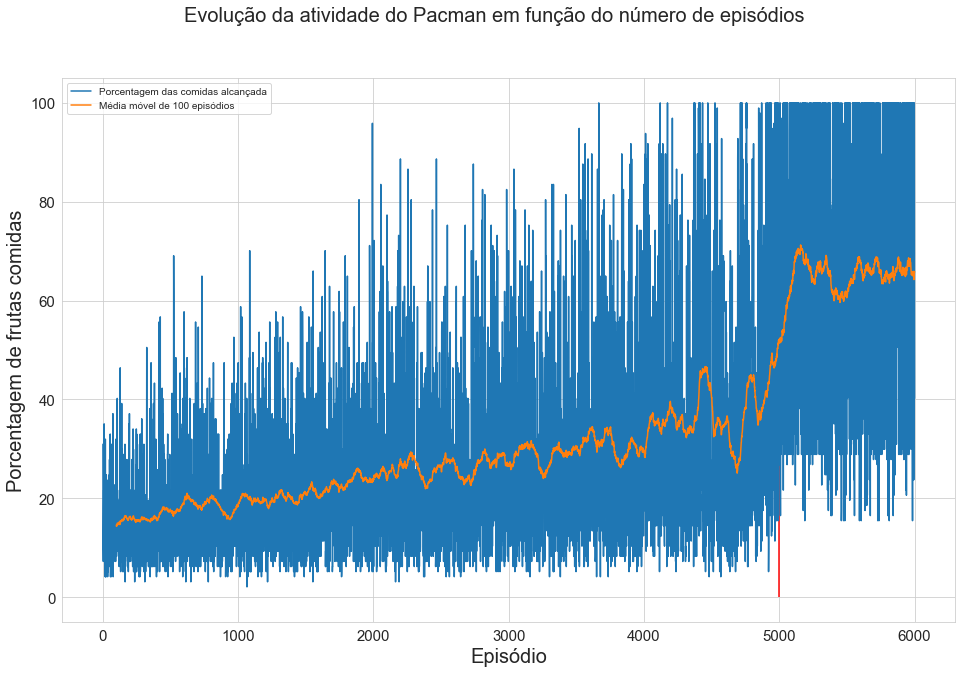

In [152]:
n = 100
fig, ax = plt.subplots(figsize=(16,10))
ax.vlines(5000, 0, 100, colors='r')
ax.plot(np.arange(1, data['numGames'] + 1), data['foodEaten']*100)
mm, = ax.plot(np.arange(n, data['numGames'] + 1), mediaMovel(data['foodEaten']*100, n))
fig.suptitle("Evolução da atividade do Pacman em função do número de episódios", fontsize=FONTSIZE)
ax.legend(['Porcentagem das comidas alcançada', 'Média móvel de {} episódios'.format(n)])
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Porcentagem de frutas comidas', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

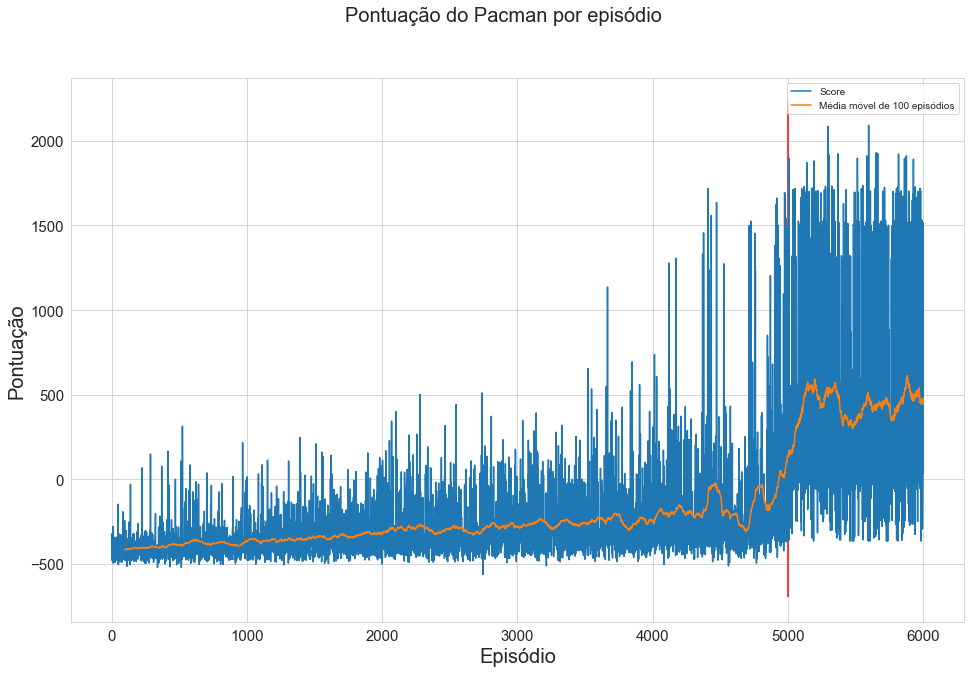

In [150]:
n = 100
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(np.arange(1, data['numGames'] + 1), data['scores'])
ax.plot(np.arange(n, data['numGames'] + 1), mediaMovel(data['scores'], n))
ymin, ymax = ax.get_ylim()
ax.vlines(5000, ymin, ymax, colors='r')
fig.suptitle("Pontuação do Pacman por episódio", fontsize=FONTSIZE)
ax.legend(['Score', 'Média móvel de {} episódios'.format(n)])
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Pontuação', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

Como é de se esperar, o comportamento da pontuação do pacman é semelhante ao do gráfico anterior: houve uma melhora expressiva na pontuação no início do período de teste.

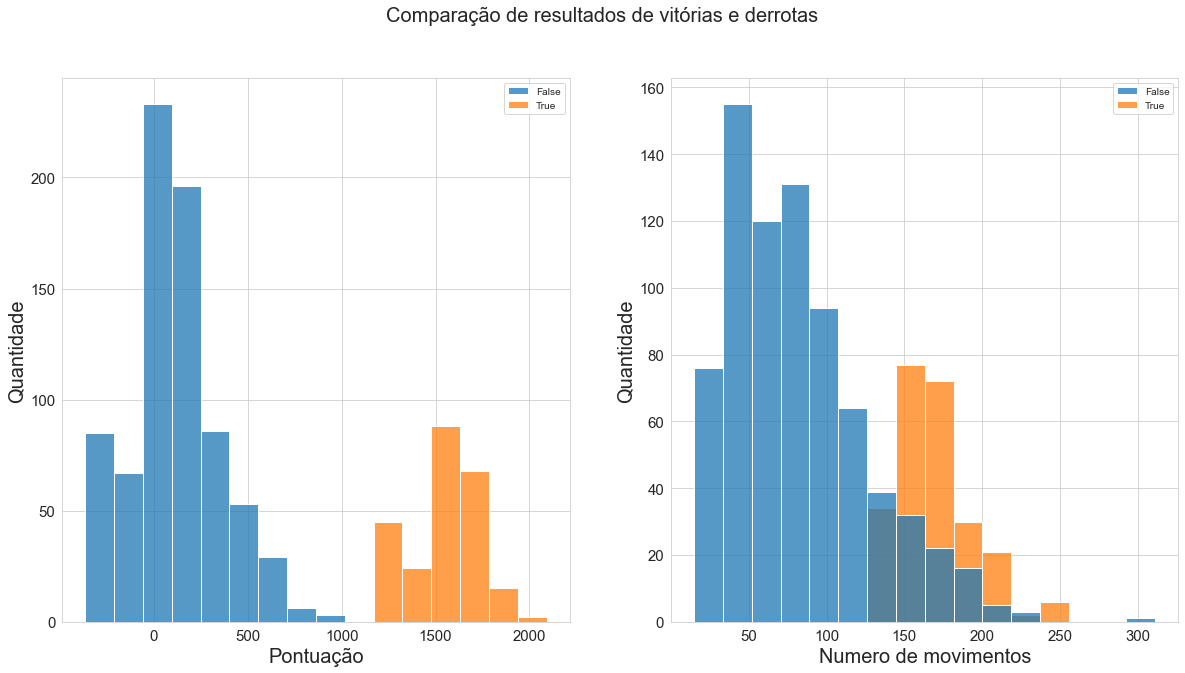

In [238]:
fig, axs = plt.subplots(figsize=(20,10), nrows=1, ncols=2)
sns.histplot(x=data['scores'][5000:], hue=data['wins'][5000:], ax=axs[0])
sns.histplot(x=data['numMoves'][5000:], hue=data['wins'][5000:], ax=axs[1])
fig.suptitle("Comparação de resultados de vitórias e derrotas", fontsize=FONTSIZE)
axs[0].set_xlabel("Pontuação", fontsize=FONTSIZE)
axs[1].set_xlabel("Numero de movimentos", fontsize=FONTSIZE)
for ax in axs:   
    ax.set_ylabel("Quantidade", fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

O gráfico acima mostra diferenças na pontuação para os casos em que o pacman vence e perde o jogo e no número de movimentos: a pontuação foi maior em jogos vencidos pelo pacman e o número de movimentos também. Tais valores fazem sentido, pois uma maior pontuação infere que o pacman comeu mais,condição necesária para vencer; e o maior número de movimentos permite concluir que o pacman não foi alcançado por nenhum fantasma e, portanto, ficou "vivo" mais tempo para vencer. 

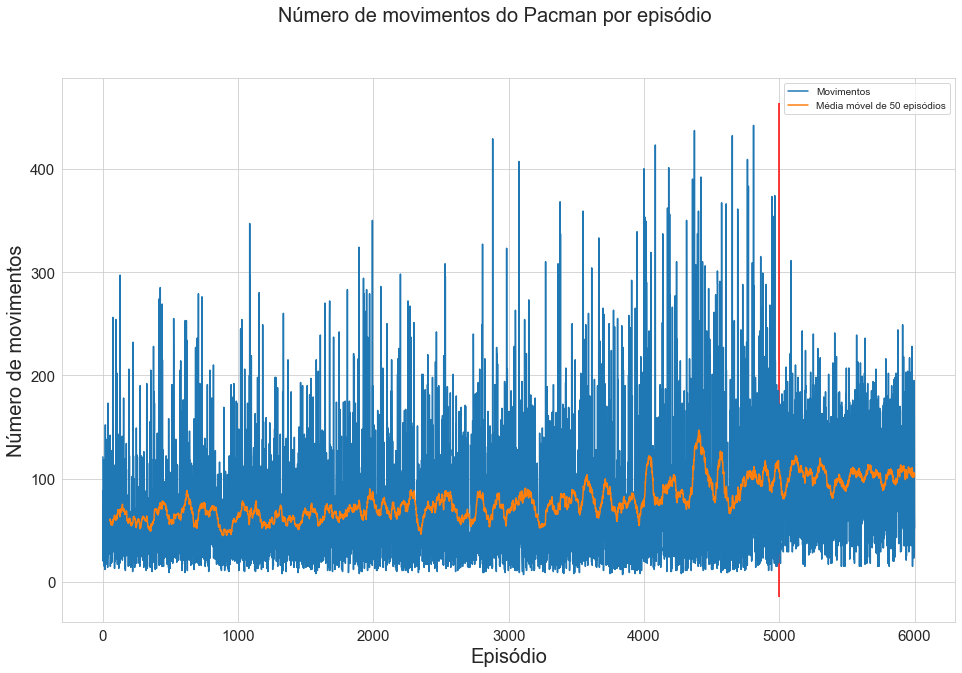

In [163]:
n = 50
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(np.arange(1, data['numGames'] + 1), data['numMoves'])
ax.plot(np.arange(n, data['numGames'] + 1), mediaMovel(data['numMoves'], n))
ymin, ymax = ax.get_ylim()
ax.vlines(5000, ymin, ymax, colors='r')
fig.suptitle("Número de movimentos do Pacman por episódio", fontsize=FONTSIZE)
ax.legend(['Movimentos', 'Média móvel de {} episódios'.format(n)])
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Número de movimentos', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

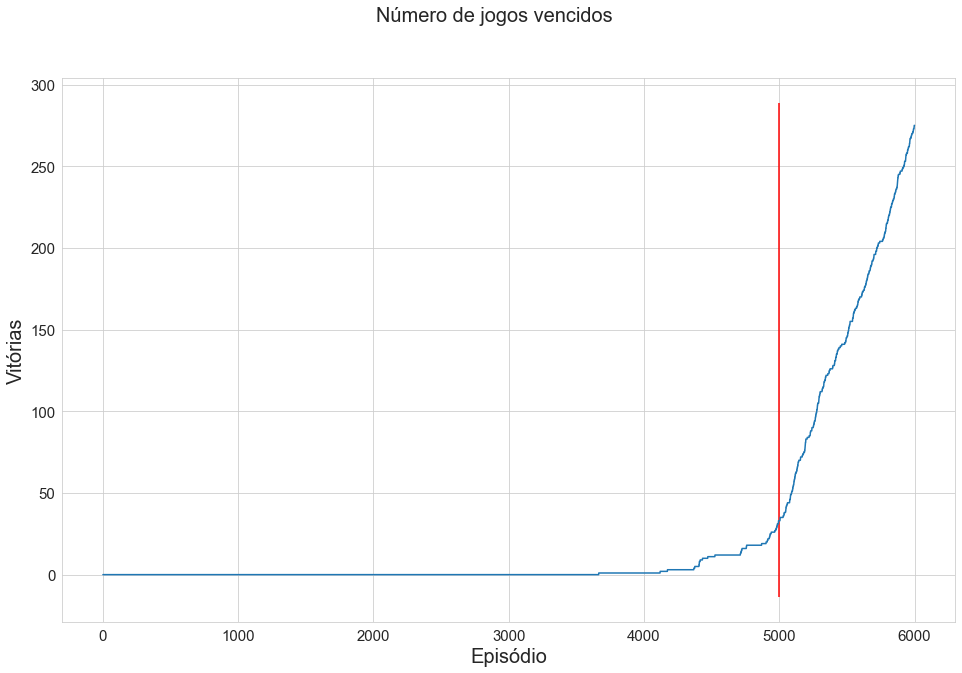

In [209]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(np.arange(1, data['numGames'] + 1), getWins(data))
ymin, ymax = ax.get_ylim()
ax.vlines(5000, ymin, ymax, colors='r')
fig.suptitle("Número de jogos vencidos", fontsize=FONTSIZE)
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Vitórias', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

Os gráficos acima mostram a progressão do número de movimentos e do número de vitórias a cada episódio. Nota-se um aumento no número de vitórias nos últimos 1000 episódios de treinamento, o que é condizente com o esperado, pois o valor de epsilon já haveria diminuído e, portanto, o pacman teria maior probabilidade de escolher movimentos pelo treinamento, e não aleatórios.

### smallClassic

Novamente, são feitos 5000 episódios de treinamento e 1000 de teste no cenário smallClassic:

In [16]:
QLearningAgent.resetState()
smallClassicArgs = setConfig( 'QLearningAgent', numTraining = 5000, numGames=6000, layout='smallClassic' )
smallClassicGames, smallClassicData = runGames( **smallClassicArgs )

Trained episode 100
Trained episode 200
Trained episode 300
Trained episode 400
Trained episode 500
Trained episode 600
Trained episode 700
Trained episode 800
Trained episode 900
Trained episode 1000
Trained episode 1100
Trained episode 1200
Trained episode 1300
Trained episode 1400
Trained episode 1500
Trained episode 1600
Trained episode 1700
Trained episode 1800
Trained episode 1900
Trained episode 2000
Trained episode 2100
Trained episode 2200
Trained episode 2300
Trained episode 2400
Trained episode 2500
Trained episode 2600
Trained episode 2700
Trained episode 2800
Trained episode 2900
Trained episode 3000
Trained episode 3100
Trained episode 3200
Trained episode 3300
Trained episode 3400
Trained episode 3500
Trained episode 3600
Trained episode 3700
Trained episode 3800
Trained episode 3900
Trained episode 4000
Trained episode 4100
Trained episode 4200
Trained episode 4300
Trained episode 4400
Trained episode 4500
Trained episode 4600
Trained episode 4700
Trained episode 4800
T

O treinamento possibilitou uma taxa de ganho de 24% nos episódios de teste, muito próxima ao valor obtido em mediumClassic. Com os resultados, é possível traçar os gráficos abaixo:

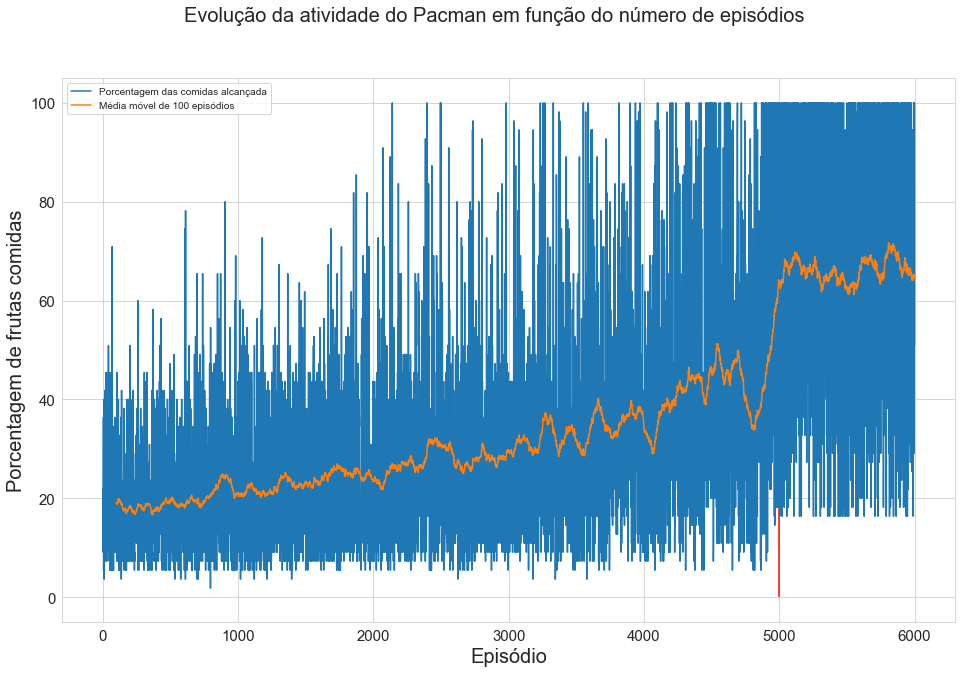

In [17]:
n = 100
fig, ax = plt.subplots(figsize=(16,10))
ax.vlines(5000, 0, 100, colors='r')
ax.plot(np.arange(1, smallClassicData['numGames'] + 1), smallClassicData['foodEaten']*100)
mm, = ax.plot(np.arange(n, smallClassicData['numGames'] + 1), mediaMovel(smallClassicData['foodEaten']*100, n))
fig.suptitle("Evolução da atividade do Pacman em função do número de episódios", fontsize=FONTSIZE)
ax.legend(['Porcentagem das comidas alcançada', 'Média móvel de {} episódios'.format(n)])
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Porcentagem de frutas comidas', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

Como no caso anterior, foi obtido um comportamento em que o número de frutas comidas e, portanto, a "proximidade" com a vitória aumentou com os episódios, e houve também um aumento no valor médio com o início do treinamento.

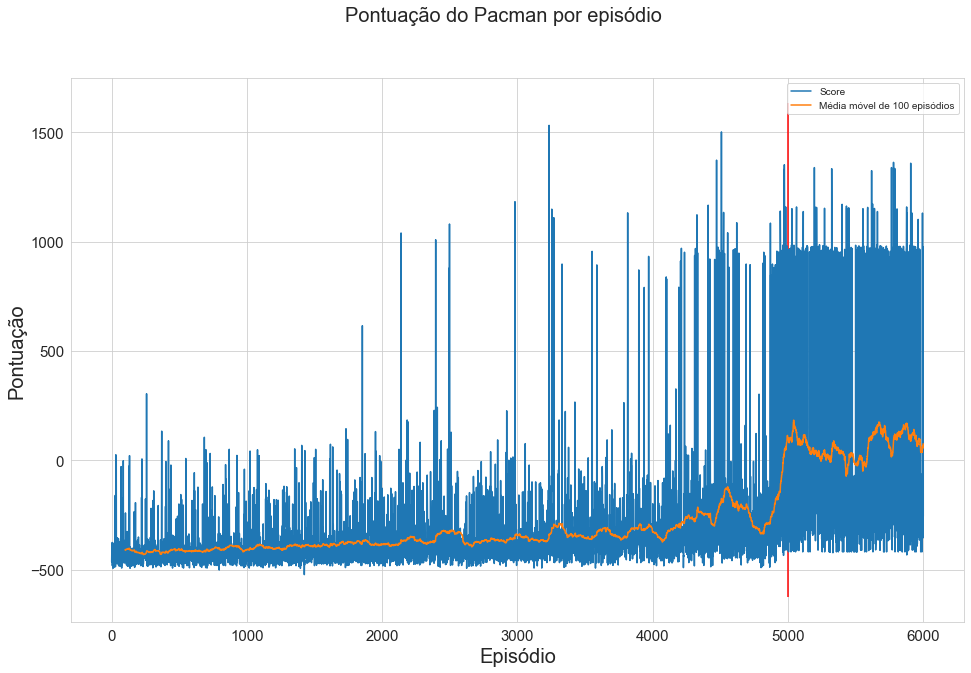

In [22]:
n = 100
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(np.arange(1, smallClassicData['numGames'] + 1), smallClassicData['scores'])
ax.plot(np.arange(n, smallClassicData['numGames'] + 1), mediaMovel(smallClassicData['scores'], n))
ymin, ymax = ax.get_ylim()
ax.vlines(5000, ymin, ymax, colors='r')
fig.suptitle("Pontuação do Pacman por episódio", fontsize=FONTSIZE)
ax.legend(['Score', 'Média móvel de {} episódios'.format(n)])
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Pontuação', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

Neste caso, nota-se que a pontuação teve variações maiores no treinamento em relação ao enterior. Isto pode estar relacionado ao fato de como o mapa era menor, se o pacman atingisse uma *pellet*, seria mais provável de chegar a um fantasma amedrontado e, assim, aumentar sua pontuação.

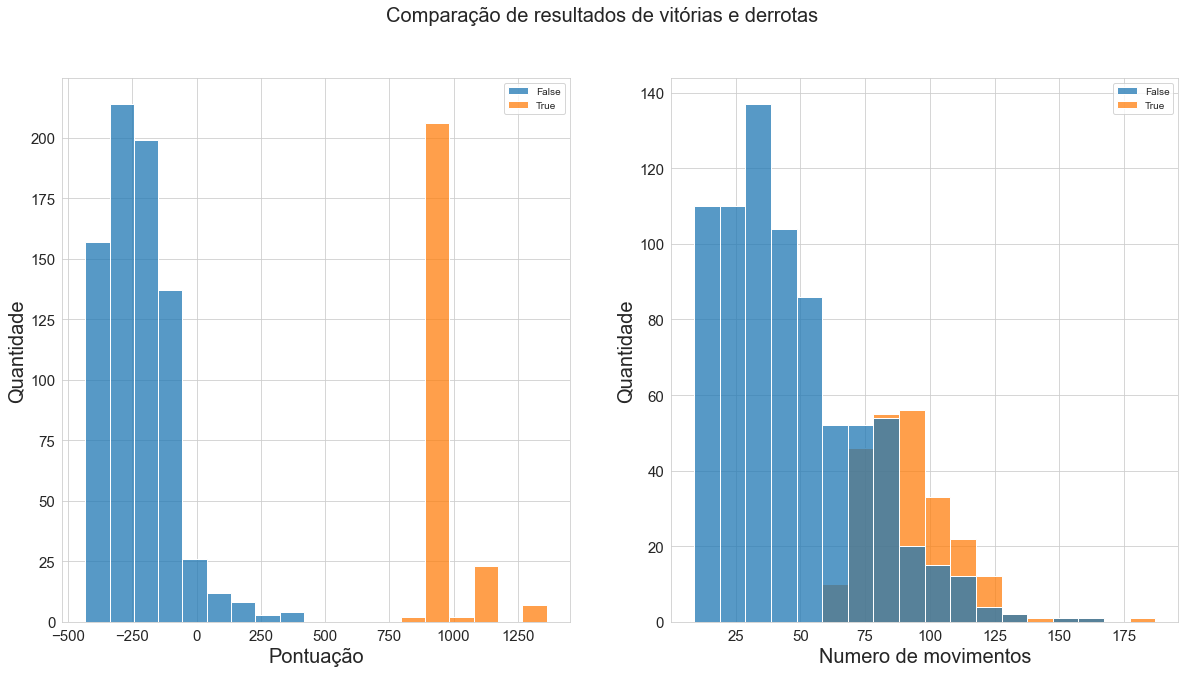

In [23]:
fig, axs = plt.subplots(figsize=(20,10), nrows=1, ncols=2)
sns.histplot(x=smallClassicData['scores'][5000:], hue=smallClassicData['wins'][5000:], ax=axs[0])
sns.histplot(x=smallClassicData['numMoves'][5000:], hue=smallClassicData['wins'][5000:], ax=axs[1])
fig.suptitle("Comparação de resultados de vitórias e derrotas", fontsize=FONTSIZE)
axs[0].set_xlabel("Pontuação", fontsize=FONTSIZE)
axs[1].set_xlabel("Numero de movimentos", fontsize=FONTSIZE)
for ax in axs:   
    ax.set_ylabel("Quantidade", fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

Como o gráfico axima mostra, o comportamento da pontuação foi diferente do anterior: neste caso, há um pico aparente no número de episódios vitoriosos com pontuação pouco menor de mil, o que poderia indicar que o pacman foi treinado a ponto de conseguir obter resultados consistentes em suas vitórias. O segundo gráfico também mostra um comportamento ligeiramente diferente: neste caso, é menor a diferença do número de movimentos de episódios em que o agente venceu em relação à configuração anterior. Tal diferença pode estar relacionada, também, pela dimensão reduzida do mapa e, por consequência, menor número de ações possíveis.

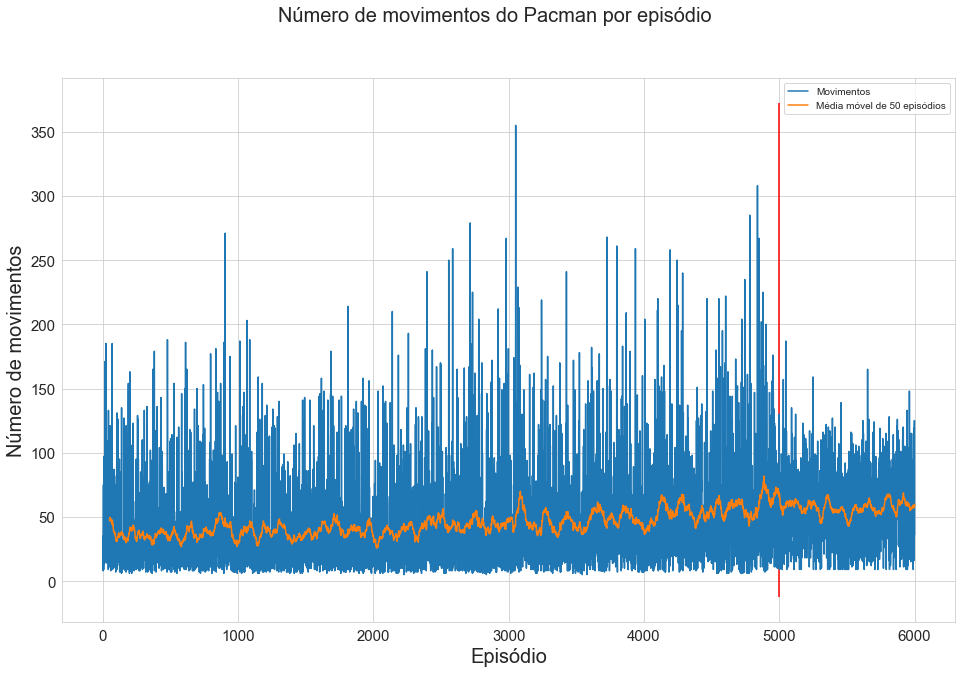

In [24]:
n = 50
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(np.arange(1, smallClassicData['numGames'] + 1), smallClassicData['numMoves'])
ax.plot(np.arange(n, smallClassicData['numGames'] + 1), mediaMovel(smallClassicData['numMoves'], n))
ymin, ymax = ax.get_ylim()
ax.vlines(5000, ymin, ymax, colors='r')
fig.suptitle("Número de movimentos do Pacman por episódio", fontsize=FONTSIZE)
ax.legend(['Movimentos', 'Média móvel de {} episódios'.format(n)])
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Número de movimentos', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

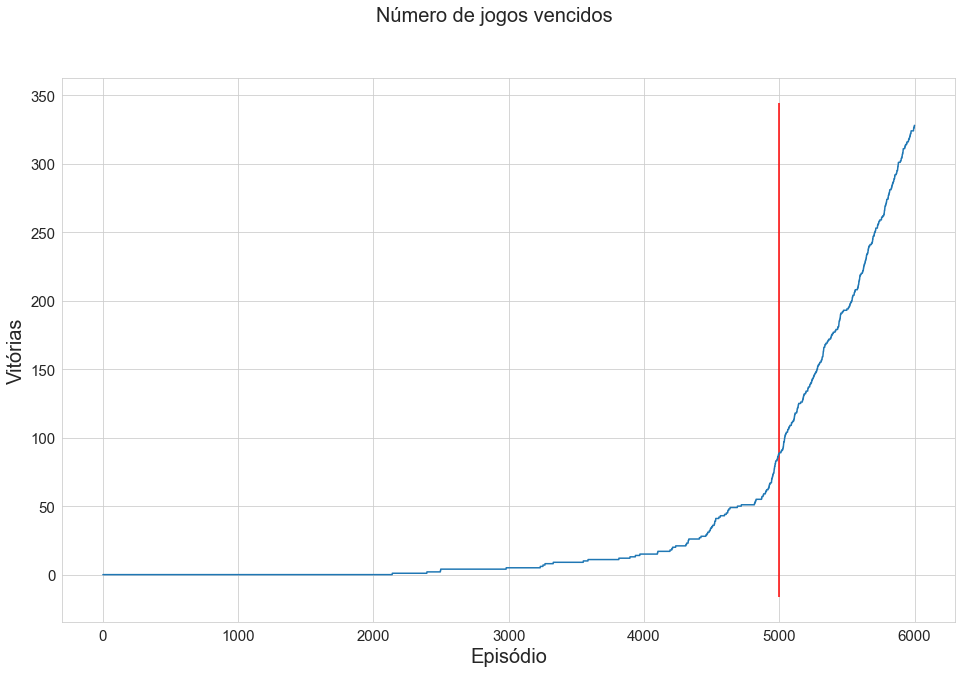

In [25]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(np.arange(1, smallClassicData['numGames'] + 1), getWins(smallClassicData))
ymin, ymax = ax.get_ylim()
ax.vlines(5000, ymin, ymax, colors='r')
fig.suptitle("Número de jogos vencidos", fontsize=FONTSIZE)
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Vitórias', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

Nota-se pelos gráficos acima que o pacman passou a vencer jogos antes que o agente usado anteriormente: antes de 3000 episódios. Como os estados foram definidos para serem independentes do tabuleiro, este comportamento pode ser devido ao fato que o pacman "visitou" um número suficiente de estados antes e atualizou seus valores de Q a ponto de vencer com menos episódios de treinamento. Entretanto, apesar de ter vencido mais que o agente anterior, como mostram os gráficos, uma menor quantidade das vitórias foi no período de teste, dado que sua taxa de vitória é menos, como exposto, o que poderia indicar que o pacman sofre overfitting por treinar excessivamente, "especializando" seus valores Q e perdendo a capacidade de generalizar suas ações nos estados.  

### originalClassic

O processo acima foi repitido no mapa originalClassic, com mesmo número de episódios de treinamento e teste:

In [10]:
QLearningAgent.resetState()
originalClassicArgs = setConfig( 'QLearningAgent', numTraining = 5000, numGames=6000, layout='originalClassic' )
originalClassicGames, originalClassicData = runGames( **originalClassicArgs )

Trained episode 100
Trained episode 200
Trained episode 300
Trained episode 400
Trained episode 500
Trained episode 600
Trained episode 700
Trained episode 800
Trained episode 900
Trained episode 1000
Trained episode 1100
Trained episode 1200
Trained episode 1300
Trained episode 1400
Trained episode 1500
Trained episode 1600
Trained episode 1700
Trained episode 1800
Trained episode 1900
Trained episode 2000
Trained episode 2100
Trained episode 2200
Trained episode 2300
Trained episode 2400
Trained episode 2500
Trained episode 2600
Trained episode 2700
Trained episode 2800
Trained episode 2900
Trained episode 3000
Trained episode 3100
Trained episode 3200
Trained episode 3300
Trained episode 3400
Trained episode 3500
Trained episode 3600
Trained episode 3700
Trained episode 3800
Trained episode 3900
Trained episode 4000
Trained episode 4100
Trained episode 4200
Trained episode 4300
Trained episode 4400
Trained episode 4500
Trained episode 4600
Trained episode 4700
Trained episode 4800
T

Neste caso, o pacman foi capaz de vencer apenas 19,9% dos jogos no período de teste. Os gráficos são mostrados a seguir. 

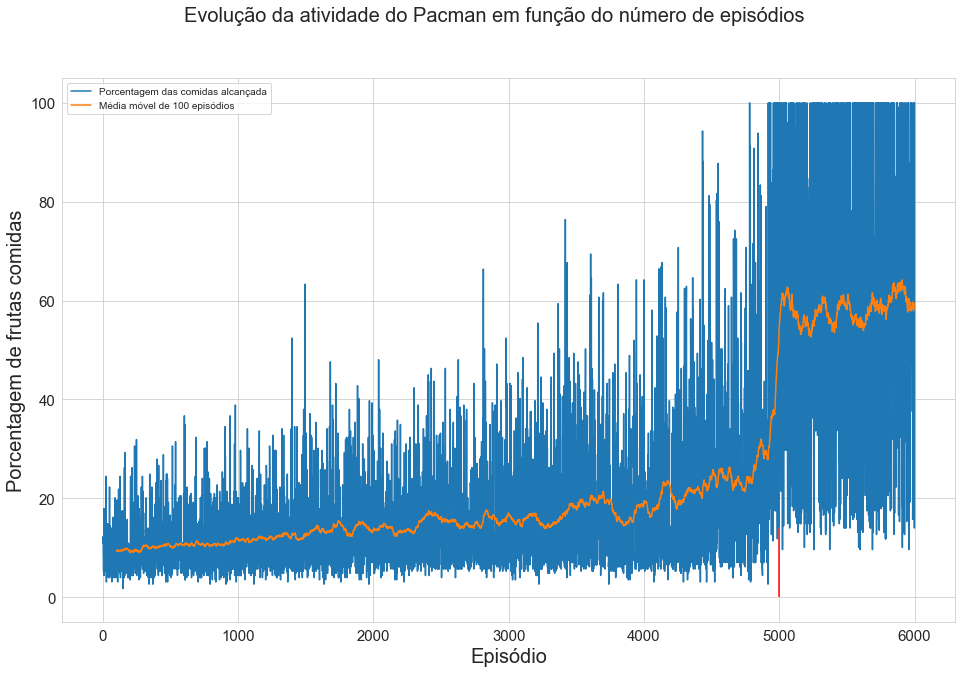

In [11]:
n = 100
fig, ax = plt.subplots(figsize=(16,10))
ax.vlines(5000, 0, 100, colors='r')
ax.plot(np.arange(1, originalClassicData['numGames'] + 1), originalClassicData['foodEaten']*100)
mm, = ax.plot(np.arange(n, originalClassicData['numGames'] + 1), mediaMovel(originalClassicData['foodEaten']*100, n))
fig.suptitle("Evolução da atividade do Pacman em função do número de episódios", fontsize=FONTSIZE)
ax.legend(['Porcentagem das comidas alcançada', 'Média móvel de {} episódios'.format(n)])
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Porcentagem de frutas comidas', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

Mais uma vez, o comportamento do agente se mostrou extremamente similar aos casos anteriores, com uma mudança rápida no valor em y a partir do fim dos testes.

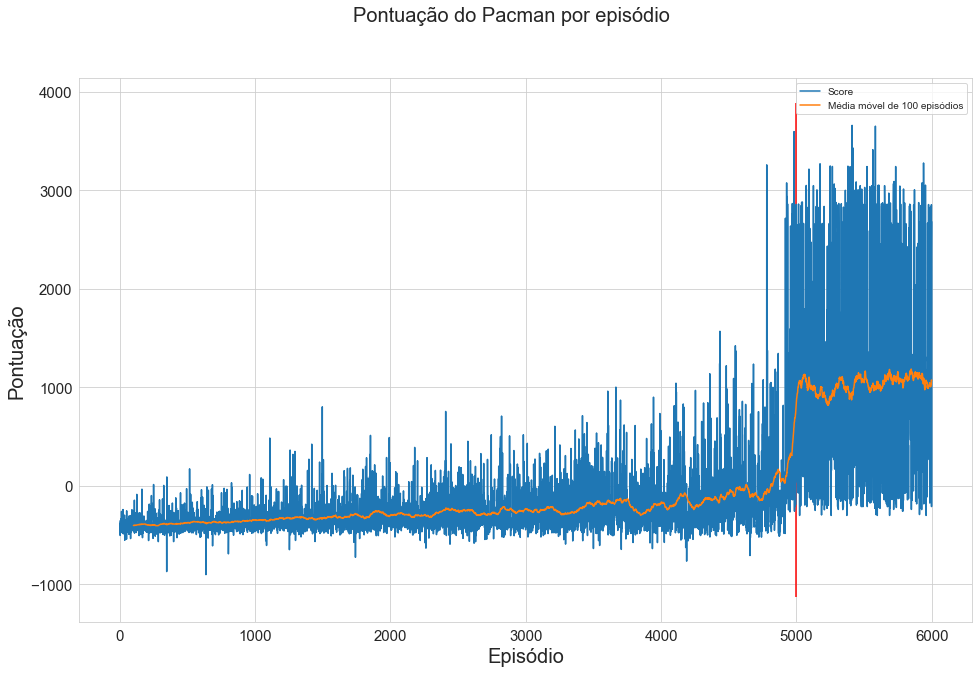

In [12]:
n = 100
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(np.arange(1, originalClassicData['numGames'] + 1), originalClassicData['scores'])
ax.plot(np.arange(n, originalClassicData['numGames'] + 1), mediaMovel(originalClassicData['scores'], n))
ymin, ymax = ax.get_ylim()
ax.vlines(5000, ymin, ymax, colors='r')
fig.suptitle("Pontuação do Pacman por episódio", fontsize=FONTSIZE)
ax.legend(['Score', 'Média móvel de {} episódios'.format(n)])
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Pontuação', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

A pontuação, como se espera, também foi superior aos casos anteriores, dado que há mais frutas e fantasmas e, portanto, possibilidades de aumento de pontuação, para o pacman.

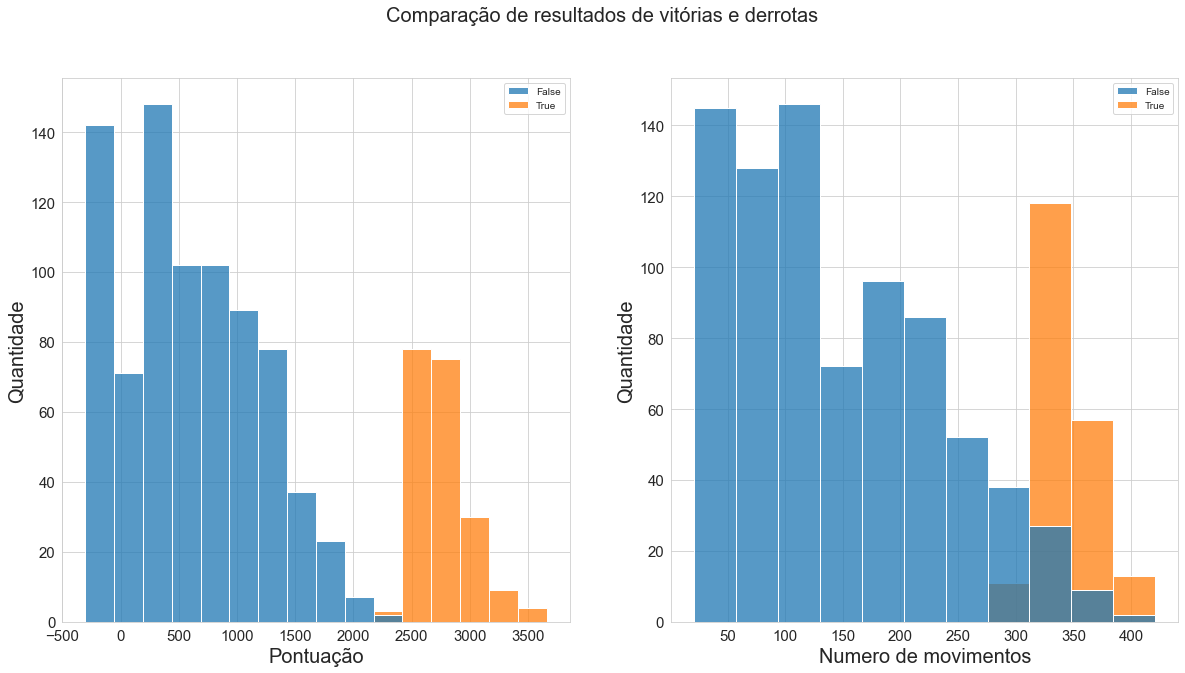

In [13]:
fig, axs = plt.subplots(figsize=(20,10), nrows=1, ncols=2)
sns.histplot(x=originalClassicData['scores'][5000:], hue=originalClassicData['wins'][5000:], ax=axs[0])
sns.histplot(x=originalClassicData['numMoves'][5000:], hue=originalClassicData['wins'][5000:], ax=axs[1])
fig.suptitle("Comparação de resultados de vitórias e derrotas", fontsize=FONTSIZE)
axs[0].set_xlabel("Pontuação", fontsize=FONTSIZE)
axs[1].set_xlabel("Numero de movimentos", fontsize=FONTSIZE)
for ax in axs:   
    ax.set_ylabel("Quantidade", fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

Neste caso, também, nota-se comportamento semelhante ao de mediumClassic, mas há sobreposição nos perfis de múmero de movimentos, especialmente para altos números de movimeto. Isto indica que o pacman se moveu muito e perdeu, possivelmente por falhas em seu treinamento.

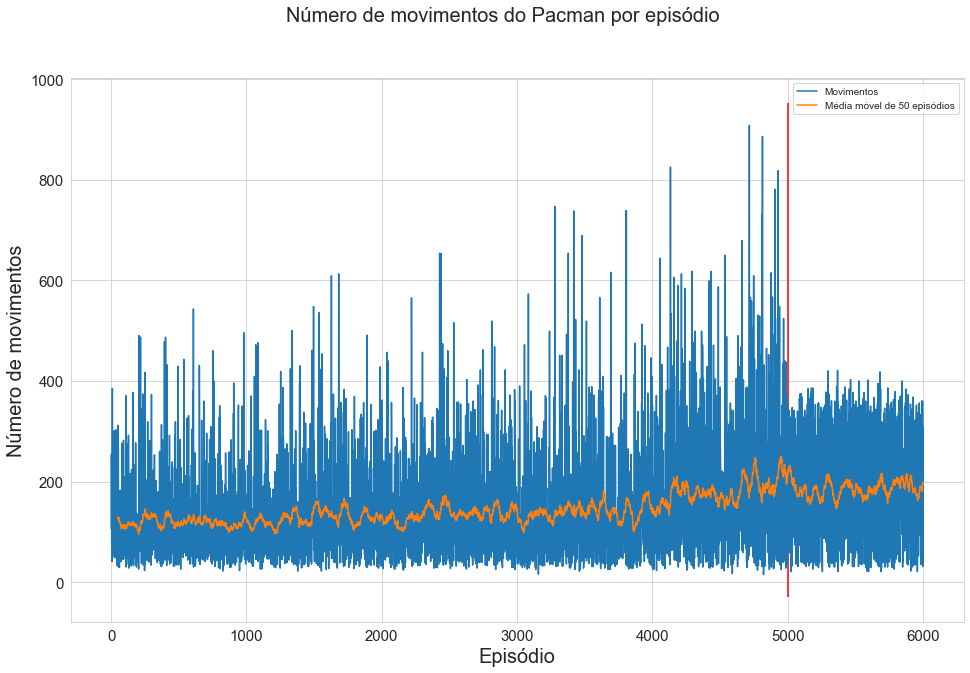

In [14]:
n = 50
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(np.arange(1, originalClassicData['numGames'] + 1), originalClassicData['numMoves'])
ax.plot(np.arange(n, originalClassicData['numGames'] + 1), mediaMovel(originalClassicData['numMoves'], n))
ymin, ymax = ax.get_ylim()
ax.vlines(5000, ymin, ymax, colors='r')
fig.suptitle("Número de movimentos do Pacman por episódio", fontsize=FONTSIZE)
ax.legend(['Movimentos', 'Média móvel de {} episódios'.format(n)])
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Número de movimentos', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

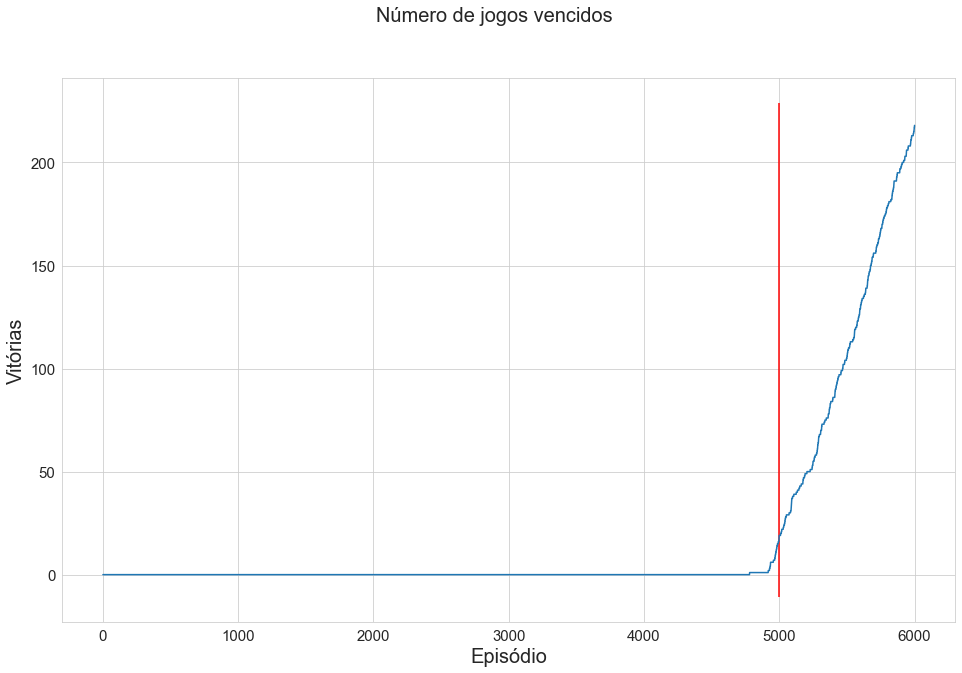

In [15]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(np.arange(1, originalClassicData['numGames'] + 1), getWins(originalClassicData))
ymin, ymax = ax.get_ylim()
ax.vlines(5000, ymin, ymax, colors='r')
fig.suptitle("Número de jogos vencidos", fontsize=FONTSIZE)
ax.set_xlabel("Episódio", fontsize=FONTSIZE)
ax.set_ylabel('Vitórias', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)

O gráfico acima, de vitórias em funçã do númeor de episódio, mais uma vez apresntou um resultado diferente dos anteriores: o agente passa a vencer jogos apenas próximo a 5000 episódios de teste, portanto, após os dois outros casos. Tal fato pode ser devido à dificuldade do agente em atingir um número grande dos estados em função da dimensão do mapa e, deste modo, não ser capaz de generalizar seu comportamento e vencer com maior frequência.

## Testes a partir do treinamento em mediumClassic
Como exposto, em teoria, os estados do agente criado devem ser robustos o suficiente para permitir que o pacman vença em outros layouts. Esta hipótese será avaliada a seguir,a partir do uso do agente treinado nos 5000 episódios em mediumClassic nos dois outros layouts.

### smallClassic
O modelo treinado anteriormente foi aplicado abaixo, com 1000 casos de testes para comparação.

In [83]:
smallArgs = {'layout': lo.getLayout('smallClassic'), 'pacman': args['pacman'], 'ghosts': args['ghosts'], 'display': args['display'], 'numGames': 1000, 'numTraining' : 0}
smallGames, smallData = runGames( **smallArgs )

Dos 1000 episódios avaliados, o pacman venceu 12,9%. Nota-se claramente que a taxa de vitória diminuiu em relação ao exemplo anterior, sendo próxima à metade. Tal diferença pode ser devido à falhas na construção de estado como, por exemplo: uma vez que são considerados fantasmas ameaçadores a 8 posições de distância, o trenamento em mediumClassic pode não ter exposto o agente a condições com estes fantasmas ameaçadores devido à dimensão do mapa. Com isso, o mapa menor pode ter levado o agente a estados para os quais não havia treinado o bastante e, eventualmente, a perder o episódio.

### originalClassic

In [210]:
largeArgs = {'layout': lo.getLayout('originalClassic'), 'pacman': args['pacman'], 'ghosts': args['ghosts'], 'display': args['display'], 'numGames': 1000, 'numTraining' : 0}
largeGames, largeData = runGames( **largeArgs )

No mapa originalClassic, o pacman venceu 14,4% dos jogos. Novamente, tal valor é inferior ao obtido anteriormente. Tal diferença pode se dar devido à maior quantidade de fantasmas no mapa, para a qual o treinamento não preparou o agente. Deste modo, ao introduzir mais fantasmas e maior distâncias entre as comidas, o pacman não pôde aplicar efetivamente o que aprendeu no treinamento. Além disso, a penalização de não comer por dez turnos pode ser excessivamente punitiva neste mapa: uma vez que o mapa é maior, o pacman pode demorar mais que 10 turnos para comer outra fruta, mesmo que escolha o melhor caminho para ela, de modo que ações que sofreram esta penalidade no treinamento idealmente não deveriam ter sofrido nos testes.

Deste modo, a configuração do agente proposta pôde generalizar seu comportamento em certa medida, como esperado, mas não permitiu desempenho igual aos testes em que era treinado em cada mapa. 

## Impacto da variação de parâmetros

### Variação de $\alpha$
O agente será treinado nas mesmas condições do exemplo anterior, mas com valor de $\alpha$ diminido para 0,1:

In [13]:
QLearningAgent.resetState()
alphaArgs = setConfig( 'QLearningAgent', numTraining = 5000, numGames=6000 )
alphaArgs['pacman'] = QLearningAgent(alpha = 0.1)
alphaGames, alphaData = runGames( **alphaArgs )

Trained episode 100
Trained episode 200
Trained episode 300
Trained episode 400
Trained episode 500
Trained episode 600
Trained episode 700
Trained episode 800
Trained episode 900
Trained episode 1000
Trained episode 1100
Trained episode 1200
Trained episode 1300
Trained episode 1400
Trained episode 1500
Trained episode 1600
Trained episode 1700
Trained episode 1800
Trained episode 1900
Trained episode 2000
Trained episode 2100
Trained episode 2200
Trained episode 2300
Trained episode 2400
Trained episode 2500
Trained episode 2600
Trained episode 2700
Trained episode 2800
Trained episode 2900
Trained episode 3000
Trained episode 3100
Trained episode 3200
Trained episode 3300
Trained episode 3400
Trained episode 3500
Trained episode 3600
Trained episode 3700
Trained episode 3800
Trained episode 3900
Trained episode 4000
Trained episode 4100
Trained episode 4200
Trained episode 4300
Trained episode 4400
Trained episode 4500
Trained episode 4600
Trained episode 4700
Trained episode 4800
T

Esta configuração, quando treinada, conseguiu a uma taxa de vitória de 44,1% no teste. Gráficos de seu comportamento são mosrtados abaixo:

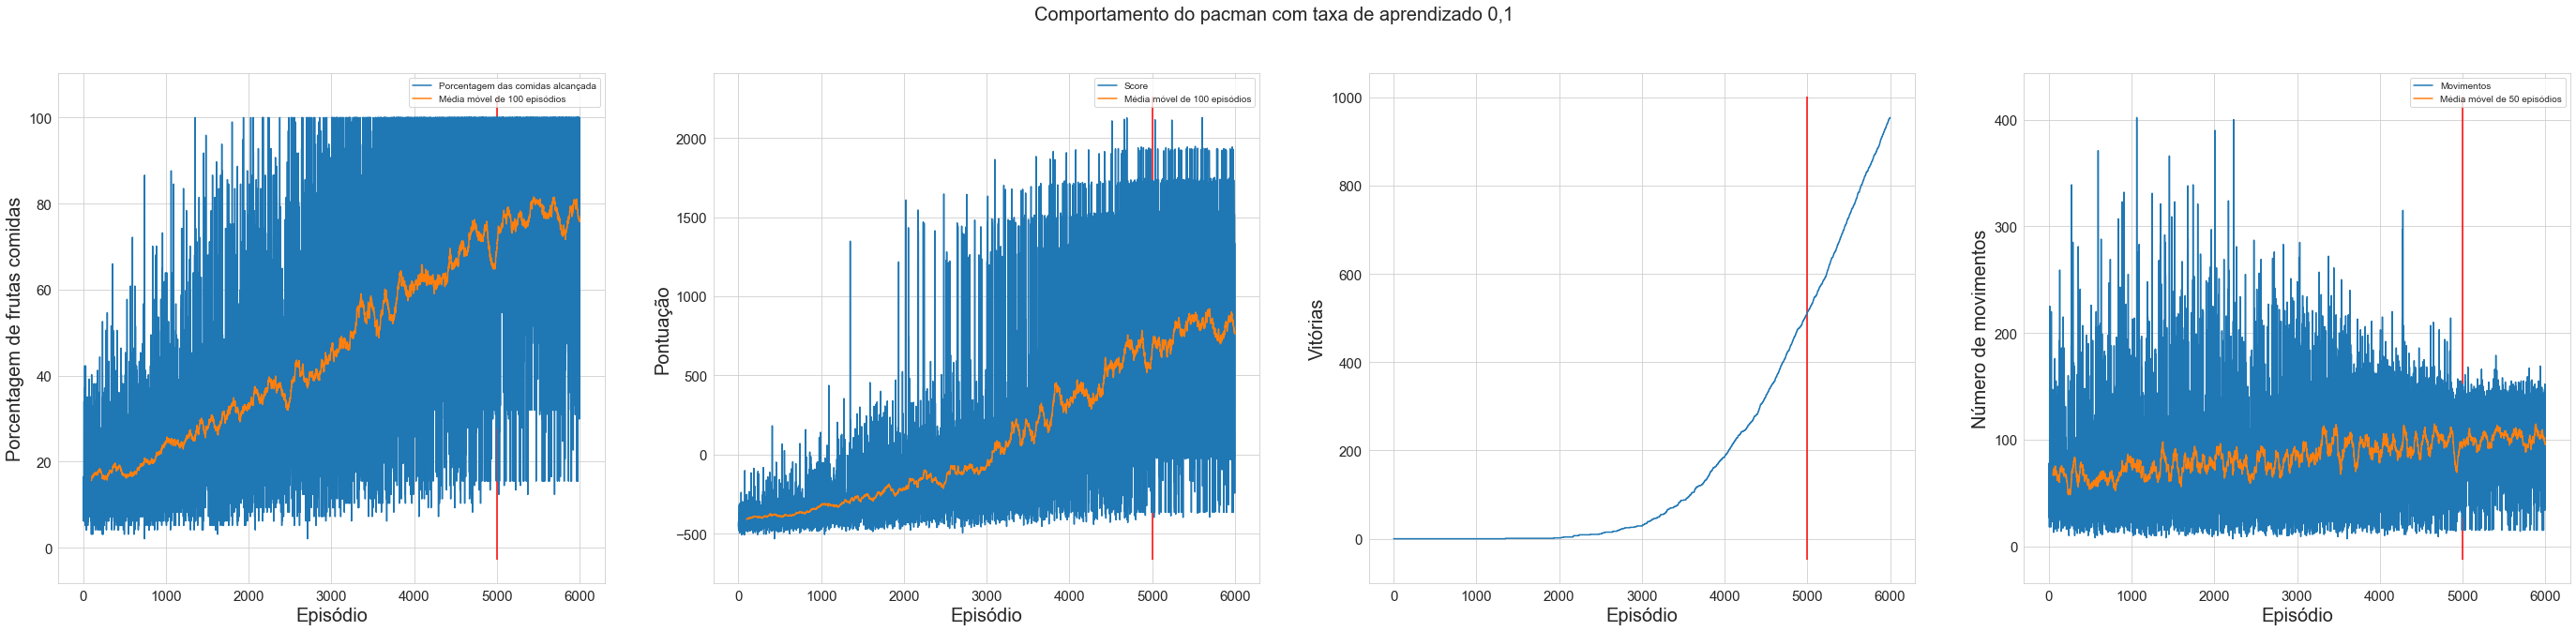

In [37]:
n = 100
fig, ax = plt.subplots(1,4, figsize=(48,10))

ax[0].plot(np.arange(1, alphaData['numGames'] + 1), alphaData['foodEaten']*100)
mm, = ax[0].plot(np.arange(n, alphaData['numGames'] + 1), mediaMovel(alphaData['foodEaten']*100, n))
fig.suptitle("Comportamento do pacman com taxa de aprendizado 0,1", fontsize=FONTSIZE)
ax[0].legend(['Porcentagem das comidas alcançada', 'Média móvel de {} episódios'.format(n)])
ax[0].set_ylabel('Porcentagem de frutas comidas', fontsize=FONTSIZE)
ax[1].plot(np.arange(1, alphaData['numGames'] + 1), alphaData['scores'])
ax[1].plot(np.arange(n, alphaData['numGames'] + 1), mediaMovel(alphaData['scores'], n))
ax[1].legend(['Score', 'Média móvel de {} episódios'.format(n)])
ax[1].set_ylabel('Pontuação', fontsize=FONTSIZE)
ax[2].plot(np.arange(1, alphaData['numGames'] + 1), getWins(alphaData))
ax[2].set_ylabel('Vitórias', fontsize=FONTSIZE)
n = 50
ax[3].plot(np.arange(1, alphaData['numGames'] + 1), alphaData['numMoves'])
ax[3].plot(np.arange(n, alphaData['numGames'] + 1), mediaMovel(alphaData['numMoves'], n))
ax[3].legend(['Movimentos', 'Média móvel de {} episódios'.format(n)])
ax[3].set_ylabel('Número de movimentos', fontsize=FONTSIZE)
for a in ax:
    a.set_xlabel("Episódio", fontsize=FONTSIZE)
    a.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)
    ymin, ymax = a.get_ylim()
    a.vlines(5000, ymin, ymax, colors='r')

Claramente, a taxa de vitórias deste agente é maior que a anterior. Além disso, a porcentagem de frutas comidas cresce muito mais rapidamente, assim como a pontuação e o número de vitórias, que começa a crescer já em 2000 episódios de treinamento.

Tal razão pode ser explicada pela estocacidade do ambiente: dado que os fantasmas se movem de maneira aleatória, taxas de aprendizado maiores – omo era o caso anterior – fazem com que o agente "esqueça" conhecimentos anteriores e baseie suas decisões em recompensas imediatas e futuras. Como os fantasmas se movem de maneira imprevisível, utilizar aprendizados anteriores é expecialmente valioso e, no caso, permitiu mais vitórias. Além disso, nota-se diminuição clara na variação do número de movimentos, o que pode indicar efetivamente uma mudança no comportamento associada ao aprendizado.

### Variação de $\gamma$

Para esta situação, o agente é testado a mesma quantidade de vezes, mas com $\gamma = 0,1$

In [29]:
QLearningAgent.resetState()
gammaArgs = setConfig( 'QLearningAgent', numTraining = 5000, numGames=6000 )
gammaArgs['pacman'] = QLearningAgent(gamma = 0.1)
gammaGames, gammaData = runGames( **gammaArgs )

Trained episode 100
Trained episode 200
Trained episode 300
Trained episode 400
Trained episode 500
Trained episode 600
Trained episode 700
Trained episode 800
Trained episode 900
Trained episode 1000
Trained episode 1100
Trained episode 1200
Trained episode 1300
Trained episode 1400
Trained episode 1500
Trained episode 1600
Trained episode 1700
Trained episode 1800
Trained episode 1900
Trained episode 2000
Trained episode 2100
Trained episode 2200
Trained episode 2300
Trained episode 2400
Trained episode 2500
Trained episode 2600
Trained episode 2700
Trained episode 2800
Trained episode 2900
Trained episode 3000
Trained episode 3100
Trained episode 3200
Trained episode 3300
Trained episode 3400
Trained episode 3500
Trained episode 3600
Trained episode 3700
Trained episode 3800
Trained episode 3900
Trained episode 4000
Trained episode 4100
Trained episode 4200
Trained episode 4300
Trained episode 4400
Trained episode 4500
Trained episode 4600
Trained episode 4700
Trained episode 4800
T

Neste caso, o agente venceu apenas 12,6% dos testes.

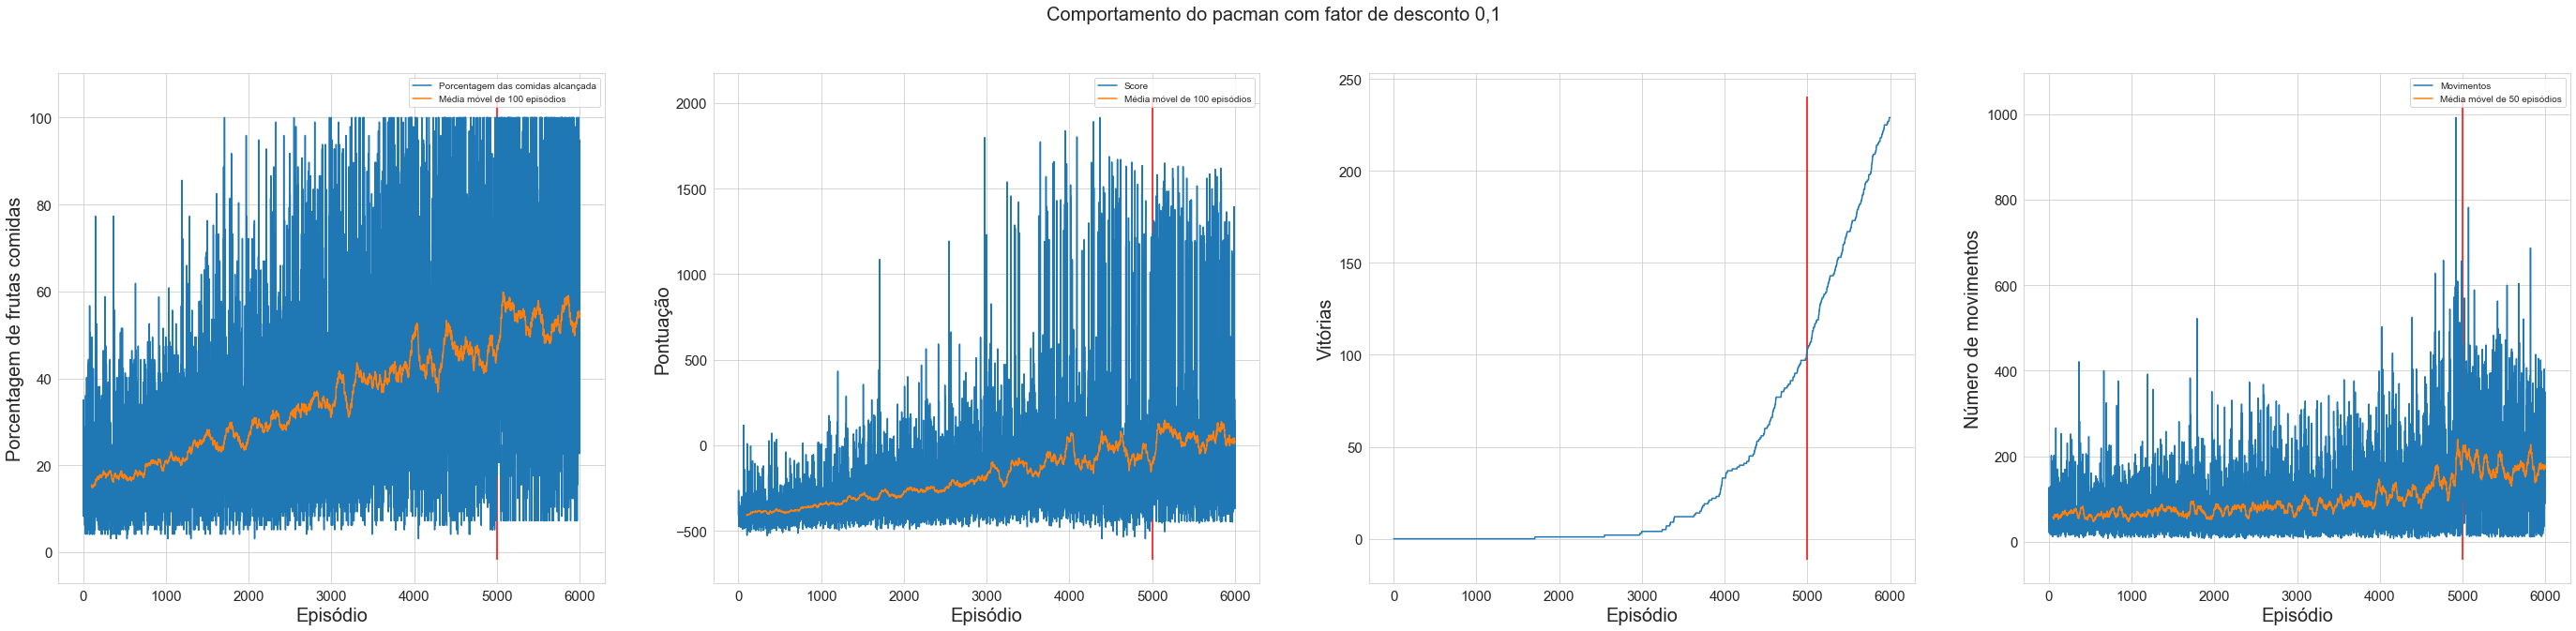

In [38]:
n = 100
fig, ax = plt.subplots(1,4, figsize=(48,10))
ax[0].plot(np.arange(1, gammaData['numGames'] + 1), gammaData['foodEaten']*100)
mm, = ax[0].plot(np.arange(n, gammaData['numGames'] + 1), mediaMovel(gammaData['foodEaten']*100, n))
fig.suptitle("Comportamento do pacman com fator de desconto 0,1", fontsize=FONTSIZE)
ax[0].legend(['Porcentagem das comidas alcançada', 'Média móvel de {} episódios'.format(n)])
ax[0].set_ylabel('Porcentagem de frutas comidas', fontsize=FONTSIZE)
ax[1].plot(np.arange(1, gammaData['numGames'] + 1), gammaData['scores'])
ax[1].plot(np.arange(n, gammaData['numGames'] + 1), mediaMovel(gammaData['scores'], n))
ax[1].legend(['Score', 'Média móvel de {} episódios'.format(n)])
ax[1].set_ylabel('Pontuação', fontsize=FONTSIZE)
ax[2].plot(np.arange(1, gammaData['numGames'] + 1), getWins(gammaData))
ax[2].set_ylabel('Vitórias', fontsize=FONTSIZE)
n = 50
ax[3].plot(np.arange(1, gammaData['numGames'] + 1), gammaData['numMoves'])
ax[3].plot(np.arange(n, gammaData['numGames'] + 1), mediaMovel(gammaData['numMoves'], n))
ax[3].legend(['Movimentos', 'Média móvel de {} episódios'.format(n)])
ax[3].set_ylabel('Número de movimentos', fontsize=FONTSIZE)
for a in ax:
    a.set_xlabel("Episódio", fontsize=FONTSIZE)
    a.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)
    ymin, ymax = a.get_ylim()
    a.vlines(5000, ymin, ymax, colors='r')

Esta configuração teve não apenas uma taxa de vitórias menor que aquela com $\gamma = 0,9 $, mas também teve pontuação média menor: enquanto a do agente anterior flutuava em torno de 500 pontos, a deste agente oscila próximo ao 0. A baixa pontuação pode ser devido a dois motivos: um fantasma ter alcançado o pacman; ou o pacman foi penalizado por tempo. 

Como $\gamma$ influencia o peso de recompensas futuras no aprendizado, o valor próximo de 0 impica e um agente que "dá pouca importância" a ações futuras e, portanto, prioriza recompensas imediatas. Este fato poderia explicar o motivo da baixa pontuação: se estiver longe de comidas, o pacman não teria incentivo para buscá-la de maneira eficaz e, portanto, é fortemente penalizado com o passar dos turnos. Esta hipótese é corroborada com o maior número de movimentos, o qe permite inferir que o pacman se moveu muito e não comeu frutas e, portanto, foi penalizado.

### Variação do número de episódios de treinamento

O agente será treinado com os parâmetros originais, mas com apenas 500 episódios de treinamento:

In [43]:
QLearningAgent.resetState()
fewerEpsArgs = setConfig( 'QLearningAgent', numTraining = 500, numGames=1500 )
fewerEpsGames, fewerEpsData = runGames( **fewerEpsArgs )

Trained episode 100
Trained episode 200
Trained episode 300
Trained episode 400
Trained episode 500


No total de 1500 episódios de treinamento e teste, o agente somente venceu uma vez, durante o treinamento. Os gráficos abaixo permitem uma análise mais aprofundada de seu comportamento:

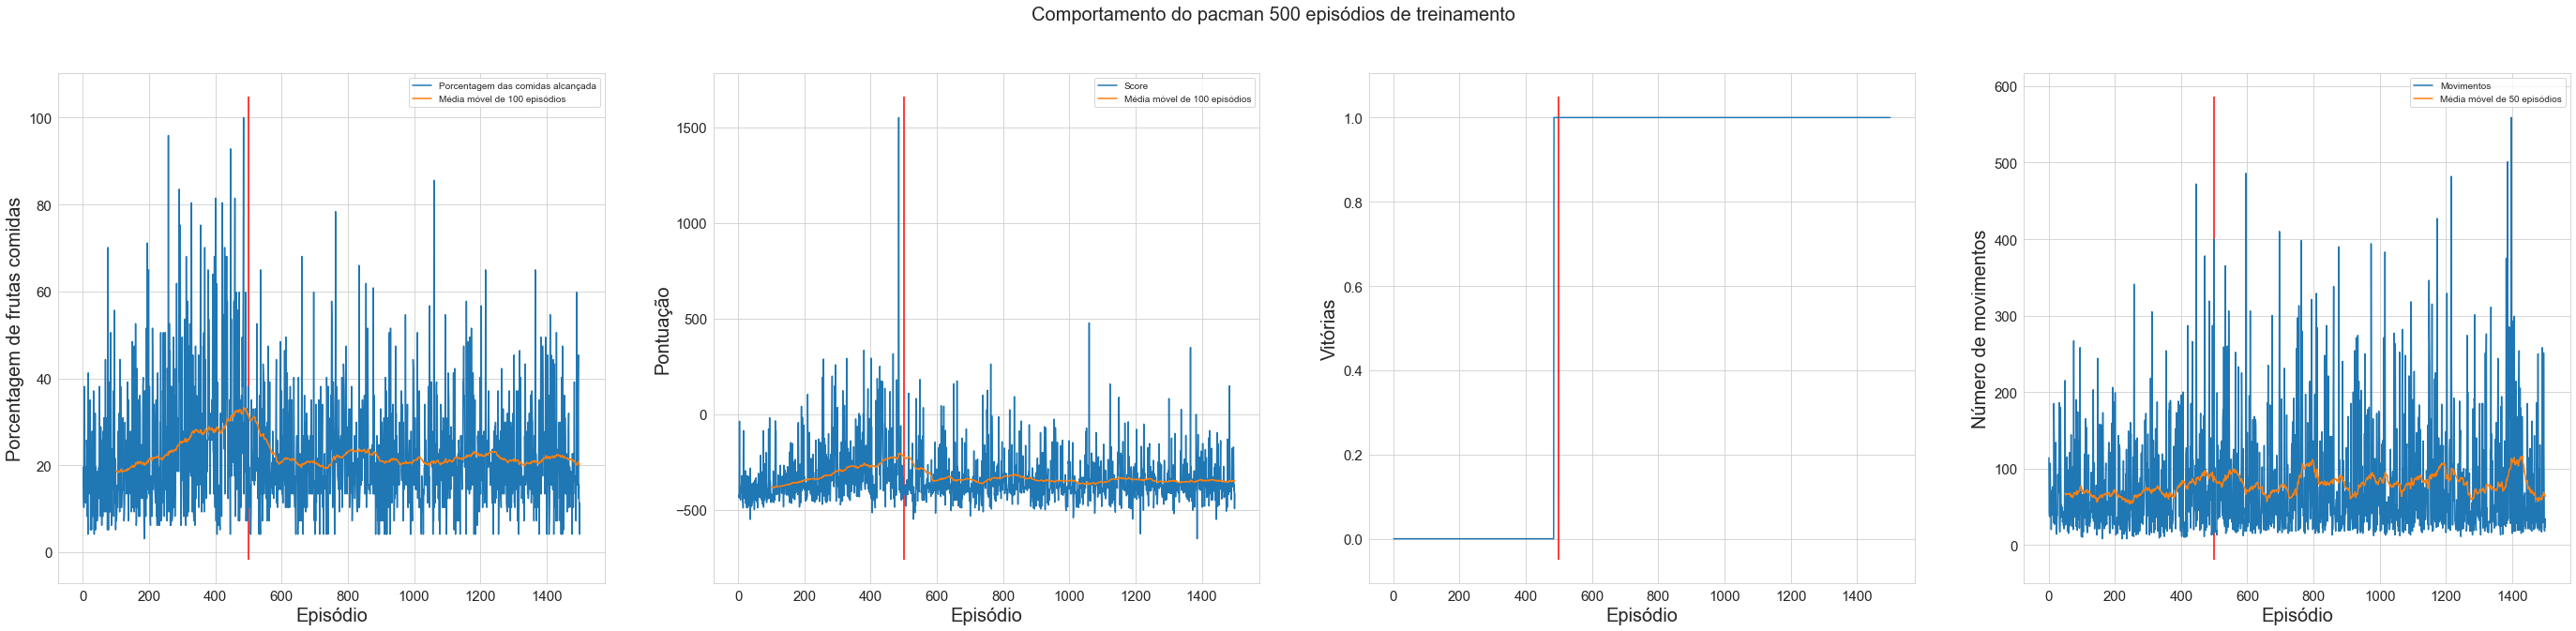

In [45]:
n = 100
fig, ax = plt.subplots(1,4, figsize=(48,10))
ax[0].plot(np.arange(1, fewerEpsData['numGames'] + 1), fewerEpsData['foodEaten']*100)
mm, = ax[0].plot(np.arange(n, fewerEpsData['numGames'] + 1), mediaMovel(fewerEpsData['foodEaten']*100, n))
fig.suptitle("Comportamento do pacman 500 episódios de treinamento", fontsize=FONTSIZE)
ax[0].legend(['Porcentagem das comidas alcançada', 'Média móvel de {} episódios'.format(n)])
ax[0].set_ylabel('Porcentagem de frutas comidas', fontsize=FONTSIZE)
ax[1].plot(np.arange(1, fewerEpsData['numGames'] + 1), fewerEpsData['scores'])
ax[1].plot(np.arange(n, fewerEpsData['numGames'] + 1), mediaMovel(fewerEpsData['scores'], n))
ax[1].legend(['Score', 'Média móvel de {} episódios'.format(n)])
ax[1].set_ylabel('Pontuação', fontsize=FONTSIZE)
ax[2].plot(np.arange(1, fewerEpsData['numGames'] + 1), getWins(fewerEpsData))
ax[2].set_ylabel('Vitórias', fontsize=FONTSIZE)
n = 50
ax[3].plot(np.arange(1, fewerEpsData['numGames'] + 1), fewerEpsData['numMoves'])
ax[3].plot(np.arange(n, fewerEpsData['numGames'] + 1), mediaMovel(fewerEpsData['numMoves'], n))
ax[3].legend(['Movimentos', 'Média móvel de {} episódios'.format(n)])
ax[3].set_ylabel('Número de movimentos', fontsize=FONTSIZE)
for a in ax:
    a.set_xlabel("Episódio", fontsize=FONTSIZE)
    a.tick_params(axis='both', which='major', labelsize=TICKFONTSIZE)
    ymin, ymax = a.get_ylim()
    a.vlines(500, ymin, ymax, colors='r')

Como mencionado, pacman venceu apenas um jogo. Os dois primeiros gráficos mostram uma piora nos resultados do agente após o final dos treinamentos: a porcentagem de frutas comidas e a pontuação diminuiram. A média da pontuação também foi inferior a 0 durante todos os episódios, o que indica claramente resultados ruins.

Tais resultados podem ser explicados pelo número de episódios de testes insuficientes: com 500 episódios, o agente não teve experiências suficientes para visitar um grande número de estados e atualizar seus valores de modo que aprendesse a tomar decisões.

# Discussão dos Resultados
Conforme explicado, o modelo de aprendizado por reforço proposto é efetivo em fazer o Pacman vencer até 25% dos jogos para 5000 episódios de treinamento. A capacidade do modelo de generalizar estados e tomar decisões foi avaliada ao treinar o agente em mediumClassic e testa-lo nos dois outros mapas que, portanto, possuiam tamanho, número de fantasmas e comidas dferentes: apesar de que as taxas de vitória sejam inferiores às obtidas anteriormente, seus valores foram superiores a 10%, o que indica certa capacidade de generalização do modelo.

Além disso, como esperado, o Pacman comia mais frutas e, portanto, aumentava sua pontuação com mais consistência com o decorrer dos episódios o que, novamente, indica que o modelo dos estados e recompensas foi útil.

Com a variação dos parâmetros, foi possível obter resultados: a diminuição na taxa de aprendizado afetou fortemente a performance do agente, dado que sua diminuição resultou em praticamente o dobro das vitórias. Já a diminuição do fator de desconto causou o efeito oposto: a pontuação média diminuiu, o número de movimentos aumentou e o pacman teve menos vitórias que no caso original. Por fim, como é esperado, a diminuição do número de casos de treinamento causou a piora no resultado do agente.

# Participação dos integrantes da dupla
- **Frederico Rappa** foi responsável pela implementação do modelo de aprendizado por reforço.
- **Guilherme Ramirez** foi responsável pela implementação do modelo evolutivo.


O restante das discussões e funções foi implementado em conjunto pela dupla.